In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

videos = pd.read_csv('KRvideos_ANSI.csv', encoding='cp949')

In [2]:
videos.describe()

,category_id,views,likes,dislikes,comment_count
count,34567.000000,3.456700e+04,3.456700e+04,3.456700e+04,3.456700e+04
mean,21.137675,4.249473e+05,1.218642e+04,5.390980e+02,2.025383e+03
std,6.675455,2.430637e+06,1.170531e+05,1.370852e+04,2.150677e+04
min,1.000000,2.050000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,22.000000,4.776850e+04,4.120000e+02,2.100000e+01,1.050000e+02
50%,24.000000,1.114960e+05,1.389000e+03,6.500000e+01,3.450000e+02
75%,25.000000,2.788665e+05,3.704500e+03,1.750000e+02,9.290000e+02
max,44.000000,1.138762e+08,5.150839e+06,1.470388e+06,1.142274e+06


Text(0, 0.5, 'views')

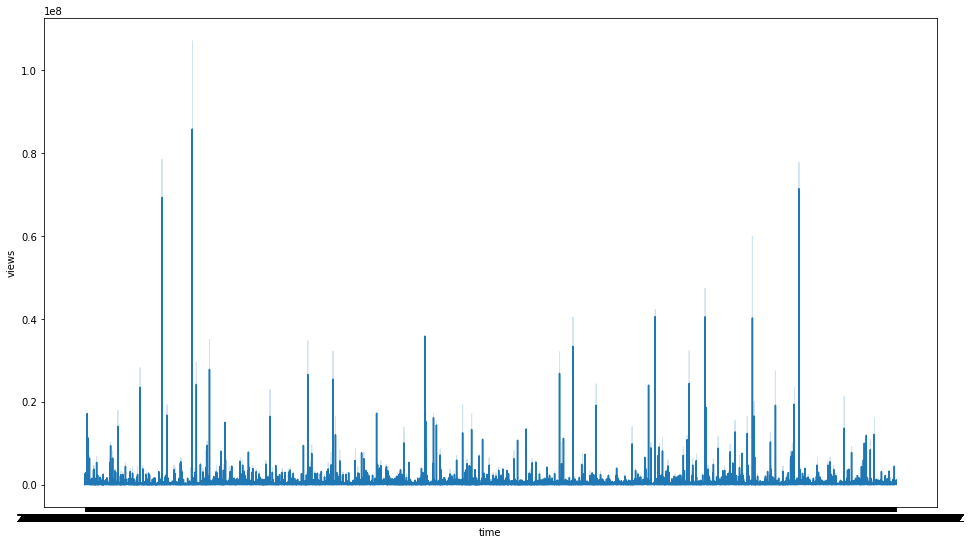

In [3]:
import seaborn as sns
plt.figure(figsize=(16, 9))
sns.lineplot(y=videos['views'], x=videos['publish_time'])
plt.xlabel('time')
plt.ylabel('views')

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['views',	'likes',	'dislikes',	'comment_count']
df_scaled = scaler.fit_transform(videos[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

          views     likes      dislikes  comment_count
0      0.000476  0.000134  1.020139e-05   5.777948e-05
1      0.000619  0.000179  1.020139e-05   6.916029e-05
2      0.000706  0.000200  9.521296e-06   7.703931e-05
3      0.000125  0.000000  6.800926e-07   8.754467e-07
4      0.000681  0.000236  7.481019e-06   4.377233e-05
...         ...       ...           ...            ...
34562  0.000247  0.000363  6.188843e-05   3.414242e-05
34563  0.000696  0.000062  1.156157e-05   5.340225e-05
34564  0.000605  0.000743  1.632222e-05   8.036601e-04
34565  0.003786  0.000000  0.000000e+00   1.532032e-04
34566  0.009654  0.000788  1.178600e-03   6.812726e-03

[34567 rows x 4 columns]


In [5]:
train = df_scaled[:24200]
test = df_scaled[-10397:]

In [6]:
def make_dataset(data, label, window_size=30): ##과거 30을 기준으로 조회수 예측하기
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [7]:
import numpy as np


feature_cols = ['likes',	'dislikes',	'comment_count']
label_cols = ['views']


train_feature = train[feature_cols]
train_label = train[label_cols]


test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 30)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))



((19336, 30, 3), (4834, 30, 3))

In [8]:
test_feature, test_label = make_dataset(test_feature, test_label, 30) 
test_feature.shape, test_label.shape


((10367, 30, 3), (10367, 1))

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
import os
#model 저장 경로 지정
model_path = '/content/drive/My Drive/Colab Notebooks/Youtube'


model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))
model.summary()

## 모델 학습
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=50, 
                    batch_size=40,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1280      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
484/484 [==============================] - 27s 51ms/step - loss: 3.4680e-04 - accuracy: 5.7379e-05 - val_loss: 3.2324e-04 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.00032, saving model to /content/drive/My Drive/Colab Notebooks/Youtube/tmp_checkpoint.h5
Epoch 2/50
484/484 [==============================] - 24s 51ms/step - loss: 2.9931e-04 - accuracy: 5.4856e-05 - val_loss: 3.0900e-04 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.00032 to 0.00031, savi

In [10]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

In [11]:
scores = model.evaluate(x_valid, y_valid)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

152/152 [==============================] - 1s 6ms/step - loss: 2.6010e-04 - accuracy: 0.0000e+00
accuracy: 0.00%


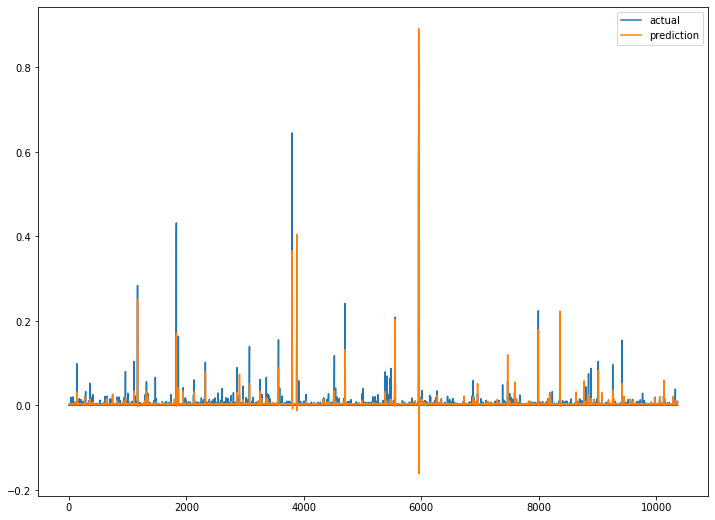

In [12]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

출처: https://teddylee777.github.io/tensorflow/LSTM%EC%9C%BC%EB%A1%9C-%EC%98%88%EC%B8%A1%ED%95%B4%EB%B3%B4%EB%8A%94-%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90-%EC%A3%BC%EA%B0%80